In [1]:
import os 
import glob
import json
import numpy as np
import cv2
import random
from tensorflow.keras.metrics import MeanIoU

from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, UpSampling2D, Reshape, Permute, Softmax, Lambda
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K

from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint


# Load Data 

In [2]:
train_path='/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/train/'
test_path="/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/test/"
valid_path='/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/valid/'

## Load Image 

In [3]:
train_data = []
for image in os.listdir(train_path):
    train_data.append(image)

test_data = []
for image in os.listdir(test_path):
    test_data.append(image)

valid_data = []
for image in os.listdir(valid_path):
    valid_data.append(image)


## Load annotation

In [4]:
train_annotation = []
for annotation in glob.glob(os.path.join(train_path, "*.json")):
    train_annotation.append(annotation)

test_annotation = []
for annotation in glob.glob(os.path.join(test_path, "*.json")):
    test_annotation.append(annotation)

valid_annotation = []
for annotation in glob.glob(os.path.join(valid_path, "*.json")):
    valid_annotation.append(annotation)

In [5]:
train_annotation=json.load(open(train_annotation[0]))
test_annotation=json.load(open(test_annotation[0]))
valid_annotation=json.load(open(valid_annotation[0]))

# Show Image and annotaiton Random Image

In [6]:
def draw_polygon(image, segmentation, color=(0, 255, 0), thickness=2):
    points = np.array(segmentation, dtype=np.int32).reshape(-1, 2)
    cv2.polylines(image, [points], isClosed=True, color=color, thickness=thickness)
    return image

In [7]:
def create_mask(image_shape, segmentation):
    mask = np.zeros(image_shape[:2], dtype=np.uint8)
    points = np.array(segmentation, dtype=np.int32).reshape(-1, 2)
    cv2.fillPoly(mask, [points], color=1)
    return mask

In [10]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

def visualize_samples(data, image_directory, num_samples=3):

    if not all(key in data for key in ('images', 'annotations')):
        raise ValueError("Data must contain 'images' and 'annotations' keys.")

    sample_indices = random.sample(range(len(data['images'])), num_samples)

    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))
    axes = axes.reshape(num_samples, 3)

    for i, index in enumerate(sample_indices):
        image_info = data['images'][index]
        annotation_info = data['annotations'][index]

        image_path = os.path.join(image_directory, image_info['file_name'])
        image = cv2.imread(image_path)

        if image is None:
            raise FileNotFoundError(f"Unable to load image at {image_path}")

        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        axes[i, 0].imshow(image_rgb)
        axes[i, 0].axis('off')
        axes[i, 0].set_title('Original Image')

        overlay = image_rgb.copy()
        draw_polygon(overlay, annotation_info['segmentation'][0])
        axes[i, 1].imshow(overlay)
        axes[i, 1].axis('off')
        axes[i, 1].set_title('Segmentation Overlay')

        mask = create_mask(image.shape, annotation_info['segmentation'][0])
        axes[i, 2].imshow(mask, cmap='gray')
        axes[i, 2].axis('off')
        axes[i, 2].set_title('Segmentation Mask')

    plt.tight_layout()
    plt.show()


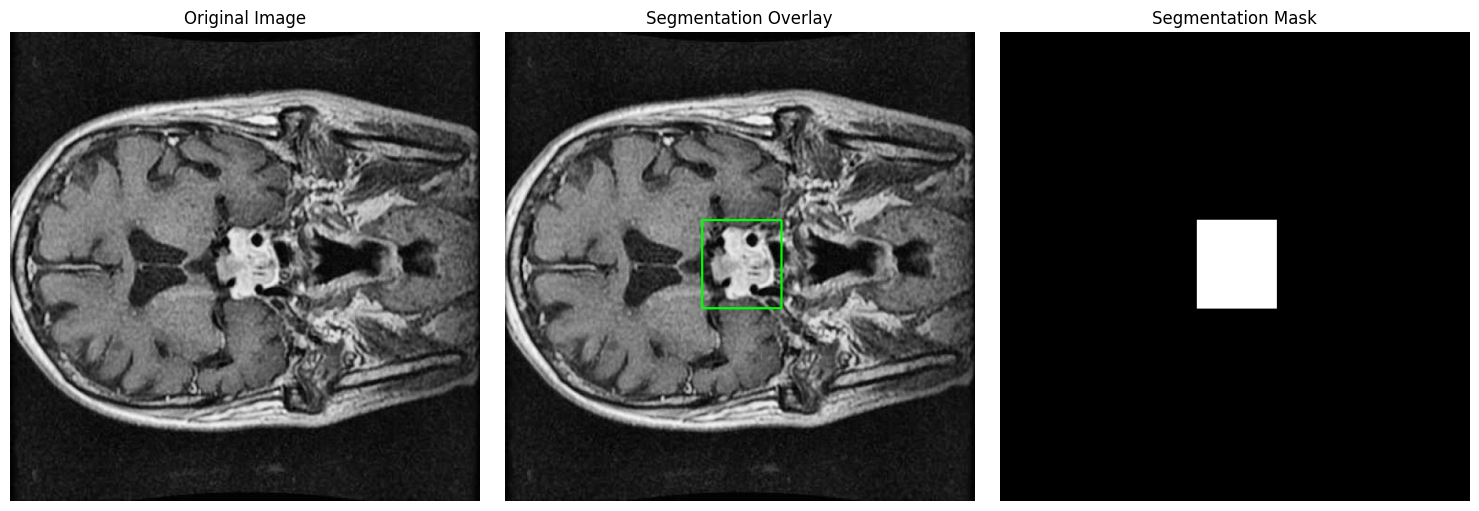

In [12]:
visualize_samples(train_annotation, train_path, num_samples=1)

# Apply Mask for all Image

In [12]:
def create_masks(mode='train'):
    if mode == 'train':
        annotations = train_annotation
        base_path = train_path
        output_dir = '/kaggle/working/train_masks/'
    elif mode == 'test':
        annotations = test_annotation
        base_path = test_path
        output_dir = '/kaggle/working/test_masks/'
    elif mode == 'val':
        annotations = valid_annotation
        base_path = valid_path
        output_dir = '/kaggle/working/val_masks/'
    else:
        raise ValueError("Invalid mode. Choose from 'train', 'test', or 'val'.")

    os.makedirs(output_dir, exist_ok=True)
    total_images = len(annotations['images'])
    processed = 0

    for image_info, annotation in zip(annotations['images'], annotations['annotations']):
        img_file_path = os.path.join(base_path, image_info['file_name'])
        mask_file_path = os.path.join(output_dir, image_info['file_name'])

        image = cv2.imread(img_file_path)
        segmentation_points = np.array(annotation['segmentation'][0], dtype=np.int32).reshape(-1, 2)
        mask_image = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)

        cv2.fillPoly(mask_image, [segmentation_points], color=(255, 255, 255))
        cv2.imwrite(mask_file_path, mask_image)

        processed += 1

    print(f"{mode.capitalize()} masks generation complete.")

def generate_masks_sequentially():
    for mode in ['train', 'test', 'val']:
        create_masks(mode)

generate_masks_sequentially()


Train masks generation complete.
Test masks generation complete.
Val masks generation complete.


# Split Data and applying Morphological operations such as opening and closing.

In [20]:
def load_data(apply_morphology=False):
    target_size = (128, 128)
    train_mask_dir = '/kaggle/working/train_masks/'
    
    X_train = [cv2.resize(cv2.imread(train_path + image['file_name']), target_size) for image in train_annotation['images']]
    y_train = [cv2.resize(cv2.imread(train_mask_dir + image['file_name'], cv2.IMREAD_GRAYSCALE), target_size) for image in train_annotation['images']]
    X_train = np.array(X_train)
    y_train = np.expand_dims(np.array(y_train), axis=-1)

    X_train = X_train.astype('float32') / 255.0
    y_train = y_train.astype('float32') / 255.0
    
    y_train = (y_train > 0.5).astype(np.float32)

    if apply_morphology:
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))  # Example kernel
        for i in range(len(y_train)):
            # Convert mask back to 2D for cv2 operations
            binary_mask = y_train[i, :, :, 0].astype(np.uint8)
            
            # Apply morphological operation (e.g., dilation)
            morphed_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)
            
            # Update the mask with the modified version
            y_train[i, :, :, 0] = morphed_mask.astype(np.float32)

    val_mask_dir = '/kaggle/working/val_masks/'
    X_val = [cv2.resize(cv2.imread(valid_path + image['file_name']), target_size) for image in valid_annotation['images']]
    y_val = [cv2.resize(cv2.imread(val_mask_dir + image['file_name'], cv2.IMREAD_GRAYSCALE), target_size) for image in valid_annotation['images']]
    X_val = np.array(X_val)
    y_val = np.expand_dims(np.array(y_val), axis=-1)

    X_val = X_val.astype('float32') / 255.0
    y_val = y_val.astype('float32') / 255.0
    y_val = (y_val > 0.5).astype(np.float32)

    return X_train, y_train, X_val, y_val


def load_test_data():
    target_size = (128, 128)
    test_mask_dir = '/kaggle/working/test_masks/'
    
    X_test = [cv2.resize(cv2.imread(test_path + image['file_name']), target_size) for image in test_annotation['images']]
    y_test = [cv2.resize(cv2.imread(test_mask_dir + image['file_name'], cv2.IMREAD_GRAYSCALE), target_size) for image in test_annotation['images']]
    
    X_test = np.array(X_test)
    y_test = np.expand_dims(np.array(y_test), axis=-1)
    
    kernel = np.ones((5, 5), np.uint8)  
    
    for i in range(len(y_test)):
        y_test[i] = cv2.morphologyEx(y_test[i], cv2.MORPH_CLOSE, kernel)
    
    X_test = X_test.astype('float32') / 255.0
    y_test = y_test.astype('float32') / 255.0
    y_test = (y_test > 0.5).astype(np.float32)

    return X_test, y_test

In [21]:
X_train,y_train,X_val,y_val = load_data(apply_morphology=True)

# Segmentation Model

In [13]:
def attention_gate(skip_connection, gating_signal, inter_channels):
   
    theta_x = layers.Conv2D(inter_channels, kernel_size=1, strides=1, padding='same')(skip_connection)
    phi_g = layers.Conv2D(inter_channels, kernel_size=1, strides=1, padding='same')(gating_signal)

    add = layers.Add()([theta_x, phi_g])
    relu = layers.Activation('relu')(add)

    psi = layers.Conv2D(1, kernel_size=1, strides=1, padding='same', activation='sigmoid')(relu)

    attn_output = layers.Multiply()([skip_connection, psi])

    return attn_output


In [70]:
def build_unet_model_with_attention():
    # Inputs
    inputs = layers.Input(shape=(128, 128, 3))

    # Encoder: contracting path
    c1 = layers.Conv2D(64, 3, padding="same", activation="relu", kernel_initializer="he_normal")(inputs)
    c1 = layers.Conv2D(64, 3, padding="same", activation="relu", kernel_initializer="he_normal")(c1)
    p1 = layers.MaxPool2D(2)(c1)
    p1 = layers.Dropout(0.3)(p1)

    c2 = layers.Conv2D(128, 3, padding="same", activation="relu", kernel_initializer="he_normal")(p1)
    c2 = layers.Conv2D(128, 3, padding="same", activation="relu", kernel_initializer="he_normal")(c2)
    p2 = layers.MaxPool2D(2)(c2)
    p2 = layers.Dropout(0.3)(p2)

    c3 = layers.Conv2D(256, 3, padding="same", activation="relu", kernel_initializer="he_normal")(p2)
    c3 = layers.Conv2D(256, 3, padding="same", activation="relu", kernel_initializer="he_normal")(c3)
    p3 = layers.MaxPool2D(2)(c3)
    p3 = layers.Dropout(0.3)(p3)

    c4 = layers.Conv2D(512, 3, padding="same", activation="relu", kernel_initializer="he_normal")(p3)
    c4 = layers.Conv2D(512, 3, padding="same", activation="relu", kernel_initializer="he_normal")(c4)
    p4 = layers.MaxPool2D(2)(c4)
    p4 = layers.Dropout(0.3)(p4)

    bottleneck = layers.Conv2D(1024, 3, padding="same", activation="relu", kernel_initializer="he_normal")(p4)
    bottleneck = layers.Conv2D(1024, 3, padding="same", activation="relu", kernel_initializer="he_normal")(bottleneck)

    # Decoder: expanding path with attention gates
    u6 = layers.Conv2DTranspose(512, 3, 2, padding="same")(bottleneck)
    attn6 = attention_gate(c4, u6, 256)
    u6 = layers.concatenate([u6, attn6])
    u6 = layers.Dropout(0.3)(u6)
    u6 = layers.Conv2D(512, 3, padding="same", activation="relu", kernel_initializer="he_normal")(u6)
    u6 = layers.Conv2D(512, 3, padding="same", activation="relu", kernel_initializer="he_normal")(u6)

    u7 = layers.Conv2DTranspose(256, 3, 2, padding="same")(u6)
    attn7 = attention_gate(c3, u7, 128)
    u7 = layers.concatenate([u7, attn7])
    u7 = layers.Dropout(0.3)(u7)
    u7 = layers.Conv2D(256, 3, padding="same", activation="relu", kernel_initializer="he_normal")(u7)
    u7 = layers.Conv2D(256, 3, padding="same", activation="relu", kernel_initializer="he_normal")(u7)

    u8 = layers.Conv2DTranspose(128, 3, 2, padding="same")(u7)
    attn8 = attention_gate(c2, u8, 64)
    u8 = layers.concatenate([u8, attn8])
    u8 = layers.Dropout(0.3)(u8)
    u8 = layers.Conv2D(128, 3, padding="same", activation="relu", kernel_initializer="he_normal")(u8)
    u8 = layers.Conv2D(128, 3, padding="same", activation="relu", kernel_initializer="he_normal")(u8)

    u9 = layers.Conv2DTranspose(64, 3, 2, padding="same")(u8)
    attn9 = attention_gate(c1, u9, 32)
    u9 = layers.concatenate([u9, attn9])
    u9 = layers.Dropout(0.3)(u9)
    u9 = layers.Conv2D(64, 3, padding="same", activation="relu", kernel_initializer="he_normal")(u9)
    u9 = layers.Conv2D(64, 3, padding="same", activation="relu", kernel_initializer="he_normal")(u9)

    outputs = layers.Conv2D(1, 1, padding="same", activation="sigmoid")(u9)

    unet_model = tf.keras.Model(inputs, outputs, name="U-Net-with-Attention")

    return unet_model


In [71]:
unet_model = build_unet_model_with_attention()

In [16]:
def dice_coefficient(y_true, y_pred):
    y_pred = K.cast(y_pred > 0.5, 'float32')  # Threshold predictions
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred)
    dice = (2. * intersection) / (union + K.epsilon())  # Avoid division by zero
    return dice

In [72]:
unet_model.compile(optimizer="adam",loss="BinaryCrossentropy",metrics=['accuracy', MeanIoU(num_classes=2),dice_coefficient])

In [16]:
from tensorflow.keras.models import load_model

unet_model = load_model('/kaggle/input/unet-attention/keras/default/1/model.h5')


In [73]:
unet_model.summary()

Model: "U-Net-with-Attention"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_260 (Conv2D) │ (None, 128, 128,  │      1,792 │ input_layer_10[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_261 (Conv2D) │ (None, 128, 128,  │     36,928 │ conv2d_260[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_36    │ (None, 64, 64,    │          0 │ conv2d_261[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_24          │ (None, 64, 64,    │          0 │ max_pooling2d_36… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_262 (Conv2D) │ (None, 64, 64,    │     73,856 │ dropout_24[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_263 (Conv2D) │ (None, 64, 64,    │    147,584 │ conv2d_262[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_37    │ (None, 32, 32,    │          0 │ conv2d_263[0][0]  │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_25          │ (None, 32, 32,    │          0 │ max_pooling2d_37… │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_264 (Conv2D) │ (None, 32, 32,    │    295,168 │ dropout_25[0][0]  │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_265 (Conv2D) │ (None, 32, 32,    │    590,080 │ conv2d_264[0][0]  │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_38    │ (None, 16, 16,    │          0 │ conv2d_265[0][0]  │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_26          │ (None, 16, 16,    │          0 │ max_pooling2d_38… │
│ (Dropout)           │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_266 (Conv2D) │ (None, 16, 16,    │  1,180,160 │ dropout_26[0][0]  │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_267 (Conv2D) │ (None, 16, 16,    │  2,359,808 │ conv2d_266[0][0]  │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_39    │ (None, 8, 8, 512) │          0 │ conv2d_267[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_27          │ (None, 8, 8, 512) │          0 │ max_pooling2d_39

 Total params: 34,862,949 (132.99 MB)

 Trainable params: 34,862,949 (132.99 MB)

 Non-trainable params: 0 (0.00 B)

In [74]:
from keras.callbacks import EarlyStopping

earlystop = EarlyStopping(monitor='val_loss',patience=5)
                            
callbacks_list = [earlystop]

unet_model.fit(X_train,y_train,epochs=30,validation_data=(X_val,y_val),callbacks=callbacks_list)

Epoch 1/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 49s 577ms/step - accuracy: 0.9132 - dice_coefficient: 0.0076 - loss: 5.4323 - mean_io_u_12: 0.4798 - val_accuracy: 0.9627 - val_dice_coefficient: 0.0000e+00 - val_loss: 0.1746 - val_mean_io_u_12: 0.4813
Epoch 2/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 242ms/step - accuracy: 0.9623 - dice_coefficient: 3.9361e-04 - loss: 0.1626 - mean_io_u_12: 0.4799 - val_accuracy: 0.9627 - val_dice_coefficient: 0.0000e+00 - val_loss: 0.1376 - val_mean_io_u_12: 0.4813
Epoch 3/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 242ms/step - accuracy: 0.9627 - dice_coefficient: 4.3331e-06 - loss: 0.1359 - mean_io_u_12: 0.4801 - val_accuracy: 0.9627 - val_dice_coefficient: 0.0000e+00 - val_loss: 0.1195 - val_mean_io_u_12: 0.4813
Epoch 4/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 242ms/step - accuracy: 0.9627 - dice_coefficient: 4.4470e-04 - loss: 0.1207 - mean_io_u_12: 0.4801 - val_accuracy: 0.9627 - val_dice_coefficient: 0.0000e+00 - val_loss: 0.1191 - val_mean_io_u_12: 0.4813
Epoch 5/30
47/47 ━━━━━━━

In [24]:
unet_model.save('model.h5')

# Saliency Map

In [25]:
import matplotlib.pyplot as plt

def compute_saliency_map(model, input_image, last_conv_layer_name):

    grad_model = tf.keras.models.Model(
        [model.input],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(input_image)
        loss = tf.reduce_mean(predictions)  # Use mean to combine all outputs if multiclass

    # Compute gradients of loss with respect to conv_outputs
    grads = tape.gradient(loss, conv_outputs)
    # Compute the guided gradients
    guided_grads = tf.reduce_mean(grads, axis=(0, 1, 2))  # Average over spatial dimensions
    # Weight the conv_outputs by the gradients
    weighted_conv_outputs = tf.reduce_mean(conv_outputs * guided_grads, axis=-1)

    # Normalize the saliency map
    saliency_map = tf.maximum(weighted_conv_outputs, 0)  # ReLU to keep positive values
    saliency_map /= tf.reduce_max(saliency_map)  # Normalize between 0 and 1

    return saliency_map.numpy()

def plot_saliency_map(input_image, saliency_map,save_path=None):

    if input_image.shape[0] == 1:  
        input_image = input_image[0]  

    if saliency_map.shape[0] == 1:  
        saliency_map = saliency_map[0]  

    plt.figure(figsize=(8, 8))

    plt.subplot(1, 2, 1)
    plt.title("Input Image")
    if input_image.ndim == 3 and input_image.shape[-1] == 3:  # RGB image
        plt.imshow(input_image)
    else:  
        plt.imshow(input_image, cmap="gray")

    plt.subplot(1, 2, 2)
    plt.title("Saliency Map")
    plt.imshow(input_image, cmap="gray")  
    plt.imshow(saliency_map, cmap="jet", alpha=0.5)  
    plt.colorbar()

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
        print(f"Saliency map saved to: {save_path}")
        
    plt.show()


Saliency map saved to: /kaggle/working/Saliency_Output.png


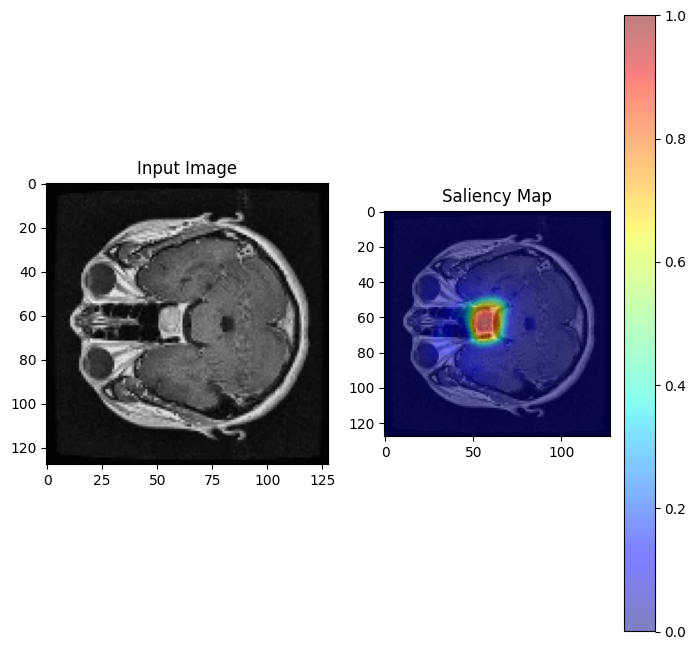

In [26]:
last_conv_layer_name = "conv2d_30"  


input_image_path = '/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/train/1000_jpg.rf.1c16148495900a466a53f121ec6af0a9.jpg'  # Adjust the image path
input_image = tf.keras.preprocessing.image.load_img(input_image_path, target_size=(128, 128))  # Resize as per your U-Net
input_image = tf.keras.preprocessing.image.img_to_array(input_image) / 255.0  # Normalize to [0, 1]
input_image = np.expand_dims(input_image, axis=0)  # Add batch dimension


saliency_map = compute_saliency_map(unet_model, input_image, last_conv_layer_name)

save_path = "/kaggle/working/Saliency_Output.png"

plot_saliency_map(input_image, saliency_map,save_path)

# Prediction

In [27]:
def predict(image_path, model, threshold=0.5):
    image = cv2.imread(image_path)
    print("Original Image Shape:", image.shape)
    
    resized_image = cv2.resize(image, (128, 128))
    print("Resized Image Shape:", resized_image.shape)
    
    input_image = np.expand_dims(resized_image, axis=0)
    
    input_image = input_image.astype('float32') / 255.0
    
    pred_mask = model.predict(input_image)
    
    pred_mask[pred_mask >= threshold] = 1  
    pred_mask[pred_mask < threshold] = 0   
    
    pred_mask = np.squeeze(pred_mask, axis=0)
    
    num_pixels = np.count_nonzero(pred_mask)
    print("shape mask",pred_mask.shape)
    return pred_mask


# Show Result

In [28]:
def compute_iou(true_mask, pred_mask):
    intersection = np.logical_and(true_mask, pred_mask).sum()
    union = np.logical_or(true_mask, pred_mask).sum()
    
    if union == 0:
        return 0.0

    iou = intersection / union
    return iou

In [29]:
def compute_dice(true_mask, pred_mask):
    intersection = np.logical_and(true_mask, pred_mask).sum()
    
    total = true_mask.sum() + pred_mask.sum()
    
    if total == 0:
        return 0.0

    dice = 2 * intersection / total
    return dice


In [30]:
def test_random_images(n=5):
    test_mask_dir = '/kaggle/working/test_masks/'
    indices = np.random.randint(0, len(test_annotation['images']), size=n)
    images = [test_annotation['images'][i] for i in indices]
    annotations = [test_annotation['annotations'][i] for i in indices]
    
    j = 1
    plt.figure(figsize=(12, 4 * 2 * n))
    for img, ann in zip(images, annotations):
        
        image = cv2.imread(test_path + img['file_name'])
        plt.subplot(n, 3, j)
        j += 1
        plt.imshow(image)
        plt.title("Input")
        
        # Predict the mask
        mask = predict(test_path + img['file_name'], unet_model)
        
        result_image = np.zeros_like(mask, dtype=np.uint8)
        result_image[mask == 1] = 255
        
        true_mask = cv2.imread(test_mask_dir + img['file_name'], cv2.IMREAD_GRAYSCALE)
        true_mask_resized = cv2.resize(true_mask, (mask.shape[1], mask.shape[0]), interpolation=cv2.INTER_NEAREST)
        true_mask_binary = (true_mask_resized > 127).astype(np.uint8)  
        
        plt.subplot(n, 3, j)
        j += 1
        plt.imshow(true_mask_binary, cmap='gray')
        plt.title("True Mask")
        
        plt.subplot(n, 3, j)
        j += 1
        plt.imshow(result_image, cmap='gray')
        plt.title("Prediction")
        
        iou_score = compute_iou(true_mask_binary, mask)
        dice_score = compute_dice(true_mask_binary, mask)
        print(f"Image: {img['file_name']}")
        print(f"  IOU Score: {iou_score:.4f}")
        print(f"  Dice Coefficient: {dice_score:.4f}")

Original Image Shape: (640, 640, 3)
Resized Image Shape: (128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
shape mask (128, 128, 1)
Image: 2031_jpg.rf.c9619df57e145824eb7b223820de054c.jpg
  IOU Score: 0.0541
  Dice Coefficient: 13.1321
Original Image Shape: (640, 640, 3)
Resized Image Shape: (128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
shape mask (128, 128, 1)
Image: 2018_jpg.rf.3d9c46b80d0ba3bf0a812975b315bf8b.jpg
  IOU Score: 0.0000
  Dice Coefficient: 0.0000
Original Image Shape: (640, 640, 3)
Resized Image Shape: (128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
shape mask (128, 128, 1)
Image: 2908_jpg.rf.ad118eecfe306c8667adde4867aa1a6f.jpg
  IOU Score: 0.0058
  Dice Coefficient: 1.4683
Original Image Shape: (640, 640, 3)
Resized Image Shape: (128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
shape mask (128, 128, 1)
Image: 2914_jpg.rf.a13c60e9941abe2c32ea64b6f607ff72.jpg
  IOU Score: 0.0000
  Dice Coefficient: 0.0000
Original Image Shape: (640, 640, 3)
Resized Image Sha

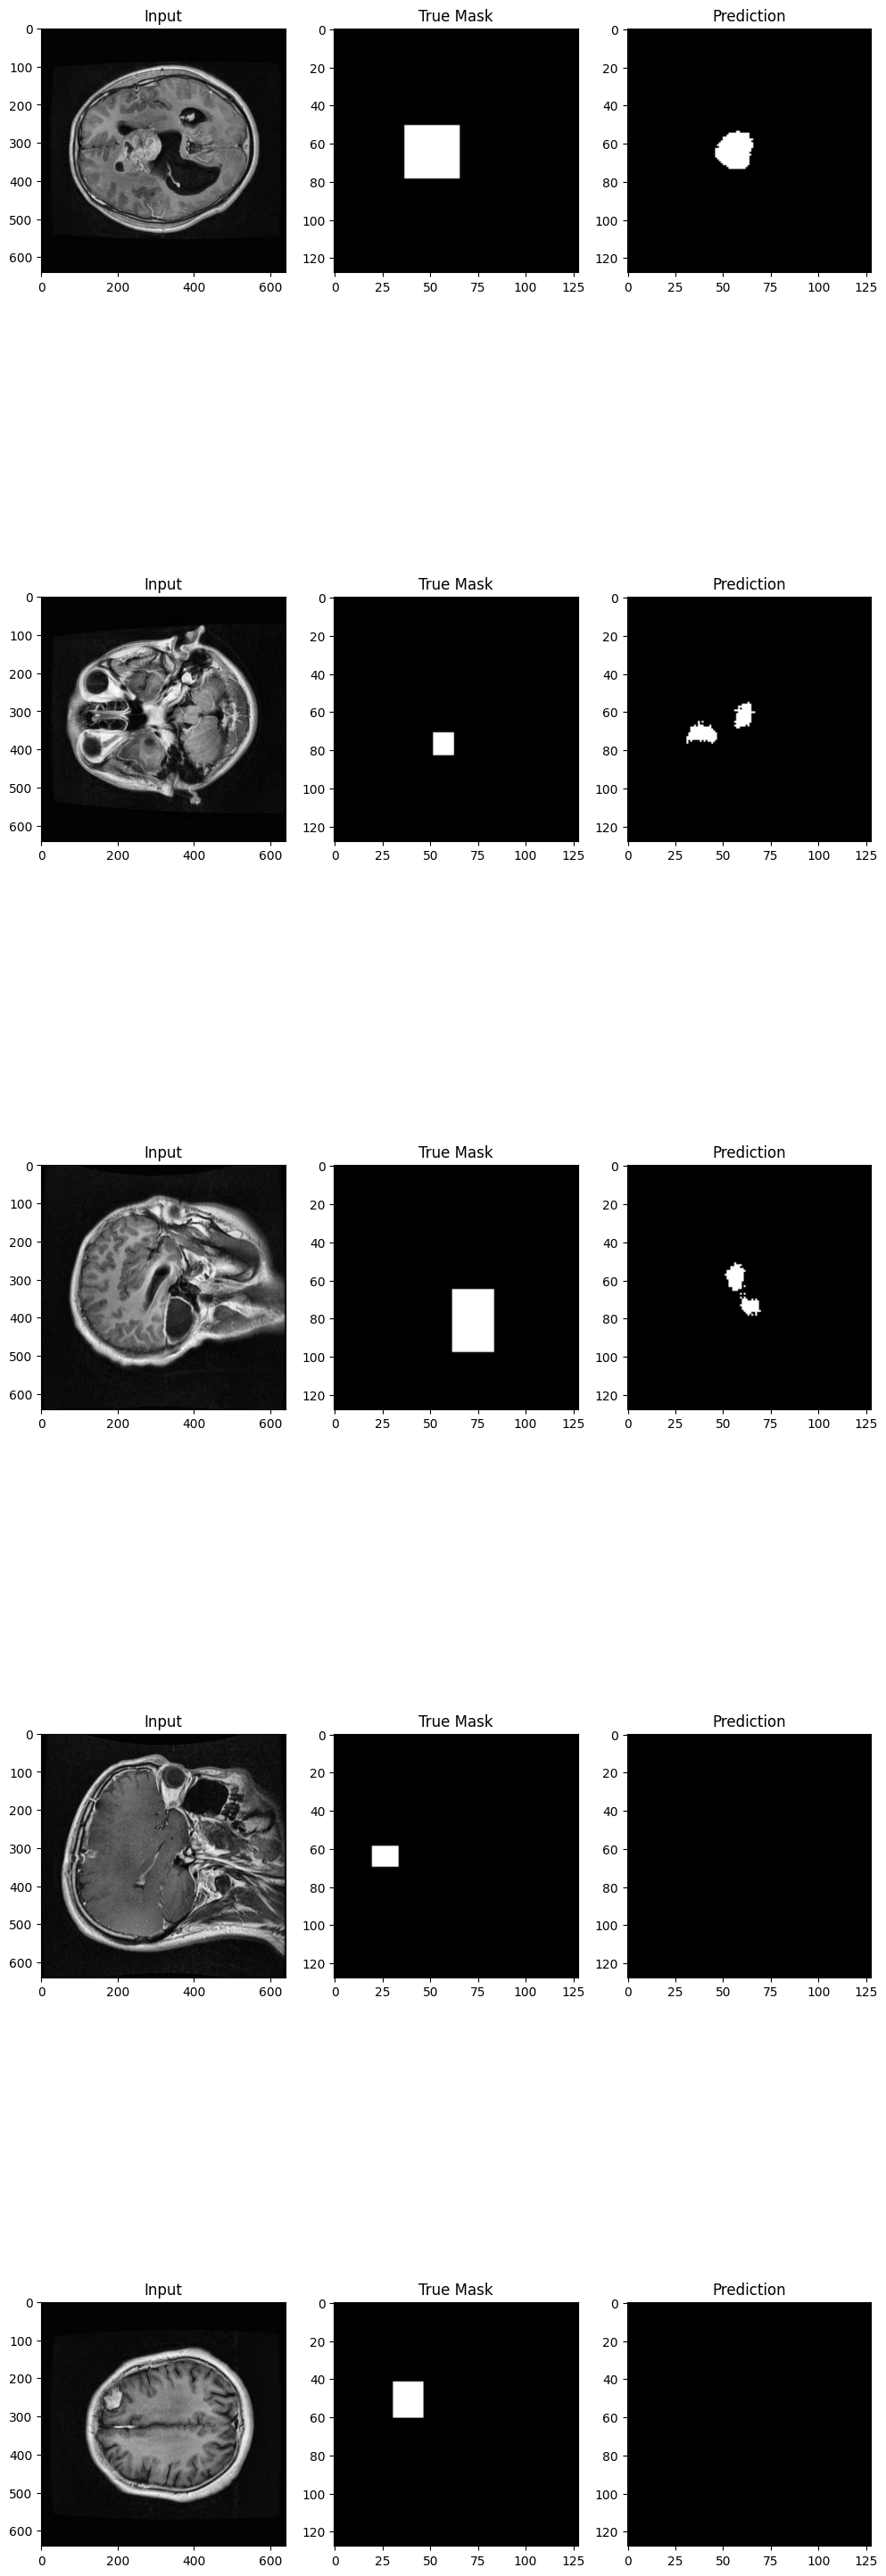

In [31]:
test_random_images()

# Link Net

In [57]:
def attention_gate(skip_connection, gating_signal, intermediate_channels):
    theta_x = layers.Conv2D(intermediate_channels, 1, strides=1, padding="same")(skip_connection)
    phi_g = layers.Conv2D(intermediate_channels, 1, strides=1, padding="same")(gating_signal)
    add = layers.Add()([theta_x, phi_g])
    relu = layers.Activation("relu")(add)
    
    psi = layers.Conv2D(1, 1, strides=1, padding="same")(relu)
    sigmoid = layers.Activation("sigmoid")(psi)
    
    attention = layers.Multiply()([skip_connection, sigmoid])
    return attention

In [58]:
def build_linknet_model_with_attention():
    # Input Layer
    inputs = layers.Input(shape=(128, 128, 3))

    def encoder_block(x, filters, dropout_rate=0.3):
            x = layers.Conv2D(filters, 3, padding="same", activation="relu", kernel_initializer="he_normal")(x)
            x = layers.Conv2D(filters, 3, padding="same", activation="relu", kernel_initializer="he_normal")(x)
            skip = x
            x = layers.MaxPool2D(2)(x)
            x = layers.Dropout(dropout_rate)(x)
            return x, skip
    
    e1, s1 = encoder_block(inputs, 64)
    e2, s2 = encoder_block(e1, 128)
    e3, s3 = encoder_block(e2, 256)
    e4, s4 = encoder_block(e3, 512)

    # Bottleneck
    bottleneck = layers.Conv2D(1024, 3, padding="same", activation="relu", kernel_initializer="he_normal")(e4)
    bottleneck = layers.Conv2D(1024, 3, padding="same", activation="relu", kernel_initializer="he_normal")(bottleneck)

    # Decoder: Upsampling + Skip Connections
    def decoder_block(x, skip_connection, filters, use_attention=False, attention_channels=128, dropout_rate=0.3):
        x = layers.Conv2DTranspose(filters, 3, strides=2, padding="same")(x)
        if use_attention:
            skip_connection = attention_gate(skip_connection, x, attention_channels)
        x = layers.Add()([x, skip_connection])  # Residual connection
        x = layers.Dropout(dropout_rate)(x)
        x = layers.Conv2D(filters, 3, padding="same", activation="relu", kernel_initializer="he_normal")(x)
        x = layers.Conv2D(filters, 3, padding="same", activation="relu", kernel_initializer="he_normal")(x)
        return x

    d4 = decoder_block(bottleneck, s4, 512, use_attention=True, attention_channels=256)
    d3 = decoder_block(d4, s3, 256, use_attention=True, attention_channels=128)
    d2 = decoder_block(d3, s2, 128, use_attention=True, attention_channels=64)
    d1 = decoder_block(d2, s1, 64, use_attention=True, attention_channels=32)

    # Output Layer
    outputs = layers.Conv2D(1, 1, padding="same", activation="sigmoid")(d1)

    # Define the Model
    linknet_model = tf.keras.Model(inputs, outputs, name="LinkNet-with-Attention")

    return linknet_model



In [59]:
# Build the model
linknet_model = build_linknet_model_with_attention()
linknet_model.summary()

Model: "LinkNet-with-Attention"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_148 (Conv2D) │ (None, 128, 128,  │      1,792 │ input_layer_6[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_149 (Conv2D) │ (None, 128, 128,  │     36,928 │ conv2d_148[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_20    │ (None, 64, 64,    │          0 │ conv2d_149[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 64, 64,    │          0 │ max_pooling2d_20… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_150 (Conv2D) │ (None, 64, 64,    │     73,856 │ dropout_16[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_151 (Conv2D) │ (None, 64, 64,    │    147,584 │ conv2d_150[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_21    │ (None, 32, 32,    │          0 │ conv2d_151[0][0]  │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 32, 32,    │          0 │ max_pooling2d_21… │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_152 (Conv2D) │ (None, 32, 32,    │    295,168 │ dropout_17[0][0]  │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_153 (Conv2D) │ (None, 32, 32,    │    590,080 │ conv2d_152[0][0]  │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_22    │ (None, 16, 16,    │          0 │ conv2d_153[0][0]  │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 16, 16,    │          0 │ max_pooling2d_22… │
│ (Dropout)           │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_154 (Conv2D) │ (None, 16, 16,    │  1,180,160 │ dropout_18[0][0]  │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_155 (Conv2D) │ (None, 16, 16,    │  2,359,808 │ conv2d_154[0][0]  │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_23    │ (None, 8, 8, 512) │          0 │ conv2d_155[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, 8, 8, 512) │          0 │ max_pooling2d_23

 Total params: 31,729,509 (121.04 MB)

 Trainable params: 31,729,509 (121.04 MB)

 Non-trainable params: 0 (0.00 B)

In [62]:
linknet_model.compile(optimizer="adam",loss="BinaryCrossentropy",metrics=['accuracy', MeanIoU(num_classes=2), dice_coefficient])

In [63]:
from keras.callbacks import EarlyStopping

earlystop = EarlyStopping(monitor='val_loss', patience=5)

callbacks_list = [earlystop]

linknet_model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val),validation_split = 0.1, callbacks=callbacks_list)

Epoch 1/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 47s 565ms/step - accuracy: 0.9622 - dice_coefficient: 0.0109 - loss: 0.1633 - mean_io_u_8: 0.4798 - val_accuracy: 0.9627 - val_dice_coefficient: 0.0000e+00 - val_loss: 0.1115 - val_mean_io_u_8: 0.4813
Epoch 2/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 213ms/step - accuracy: 0.9620 - dice_coefficient: 0.0000e+00 - loss: 0.1114 - mean_io_u_8: 0.4797 - val_accuracy: 0.9627 - val_dice_coefficient: 0.0000e+00 - val_loss: 0.1100 - val_mean_io_u_8: 0.4813
Epoch 3/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 214ms/step - accuracy: 0.9631 - dice_coefficient: 0.0000e+00 - loss: 0.1077 - mean_io_u_8: 0.4803 - val_accuracy: 0.9627 - val_dice_coefficient: 0.0000e+00 - val_loss: 0.1058 - val_mean_io_u_8: 0.4813
Epoch 4/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 214ms/step - accuracy: 0.9632 - dice_coefficient: 0.0000e+00 - loss: 0.1057 - mean_io_u_8: 0.4803 - val_accuracy: 0.9627 - val_dice_coefficient: 0.0000e+00 - val_loss: 0.1068 - val_mean_io_u_8: 0.4813
Epoch 5/30
47/47 ━━━━━━━━━━━━━━━

Saliency map saved to: /kaggle/working/LinkNet-Saliency_Output.png


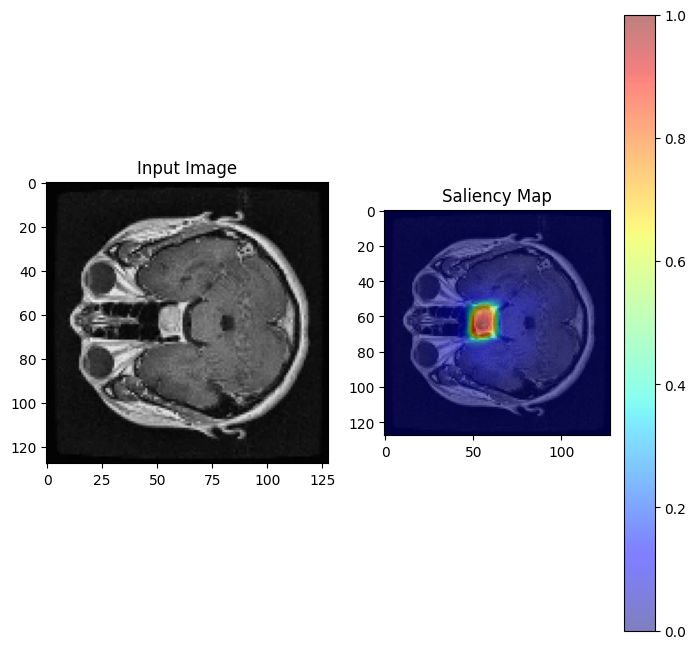

In [37]:
last_conv_layer_name = "conv2d_61"  

# Load and preprocess the input image
input_image_path = '/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/train/1000_jpg.rf.1c16148495900a466a53f121ec6af0a9.jpg'  
input_image = tf.keras.preprocessing.image.load_img(input_image_path, target_size=(128, 128))  
input_image = tf.keras.preprocessing.image.img_to_array(input_image) / 255.0  
input_image = np.expand_dims(input_image, axis=0)  

# Compute the saliency map
saliency_map = compute_saliency_map(linknet_model, input_image, last_conv_layer_name)

save_path = "/kaggle/working/LinkNet-Saliency_Output.png"
plot_saliency_map(input_image, saliency_map,save_path)

In [38]:
def test_random_images(n=5):
    test_mask_dir = '/kaggle/working/test_masks/'
    indices = np.random.randint(0, len(test_annotation['images']), size=n)
    images = [test_annotation['images'][i] for i in indices]
    annotations = [test_annotation['annotations'][i] for i in indices]
    
    j = 1
    plt.figure(figsize=(12, 4 * 2 * n))
    for img, ann in zip(images, annotations):
        
        image = cv2.imread(test_path + img['file_name'])
        plt.subplot(n, 3, j)
        j += 1
        plt.imshow(image)
        plt.title("Input")
        
        # Predict the mask
        mask = predict(test_path + img['file_name'], linknet_model)
        
        result_image = np.zeros_like(mask, dtype=np.uint8)
        result_image[mask == 1] = 255
        
        true_mask = cv2.imread(test_mask_dir + img['file_name'], cv2.IMREAD_GRAYSCALE)
        true_mask_resized = cv2.resize(true_mask, (mask.shape[1], mask.shape[0]), interpolation=cv2.INTER_NEAREST)
        true_mask_binary = (true_mask_resized > 127).astype(np.uint8)  
        
        plt.subplot(n, 3, j)
        j += 1
        plt.imshow(true_mask_binary, cmap='gray')
        plt.title("True Mask")
        
        plt.subplot(n, 3, j)
        j += 1
        plt.imshow(result_image, cmap='gray')
        plt.title("Prediction")
        
        iou_score = compute_iou(true_mask_binary, mask)
        dice_score = compute_dice(true_mask_binary, mask)
        print(f"Image: {img['file_name']}")
        print(f"  IOU Score: {iou_score:.4f}")
        print(f"  Dice Coefficient: {dice_score:.4f}")

Original Image Shape: (640, 640, 3)
Resized Image Shape: (128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 760ms/step
shape mask (128, 128, 1)
Image: 2468_jpg.rf.3d04a6d6fb7d0dea45ebdcc9ce7d4c98.jpg
  IOU Score: 0.0031
  Dice Coefficient: 0.7891
Original Image Shape: (640, 640, 3)
Resized Image Shape: (128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
shape mask (128, 128, 1)
Image: 244_jpg.rf.65cbfcb7b085a1a1b55d83f611eb07f7.jpg
  IOU Score: 0.0000
  Dice Coefficient: 0.0000
Original Image Shape: (640, 640, 3)
Resized Image Shape: (128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
shape mask (128, 128, 1)
Image: 2914_jpg.rf.a13c60e9941abe2c32ea64b6f607ff72.jpg
  IOU Score: 0.0000
  Dice Coefficient: 0.0000
Original Image Shape: (640, 640, 3)
Resized Image Shape: (128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
shape mask (128, 128, 1)
Image: 1727_jpg.rf.bb87250fbe9b279286bf5e70c7218ae6.jpg
  IOU Score: 0.0886
  Dice Coefficient: 20.8302


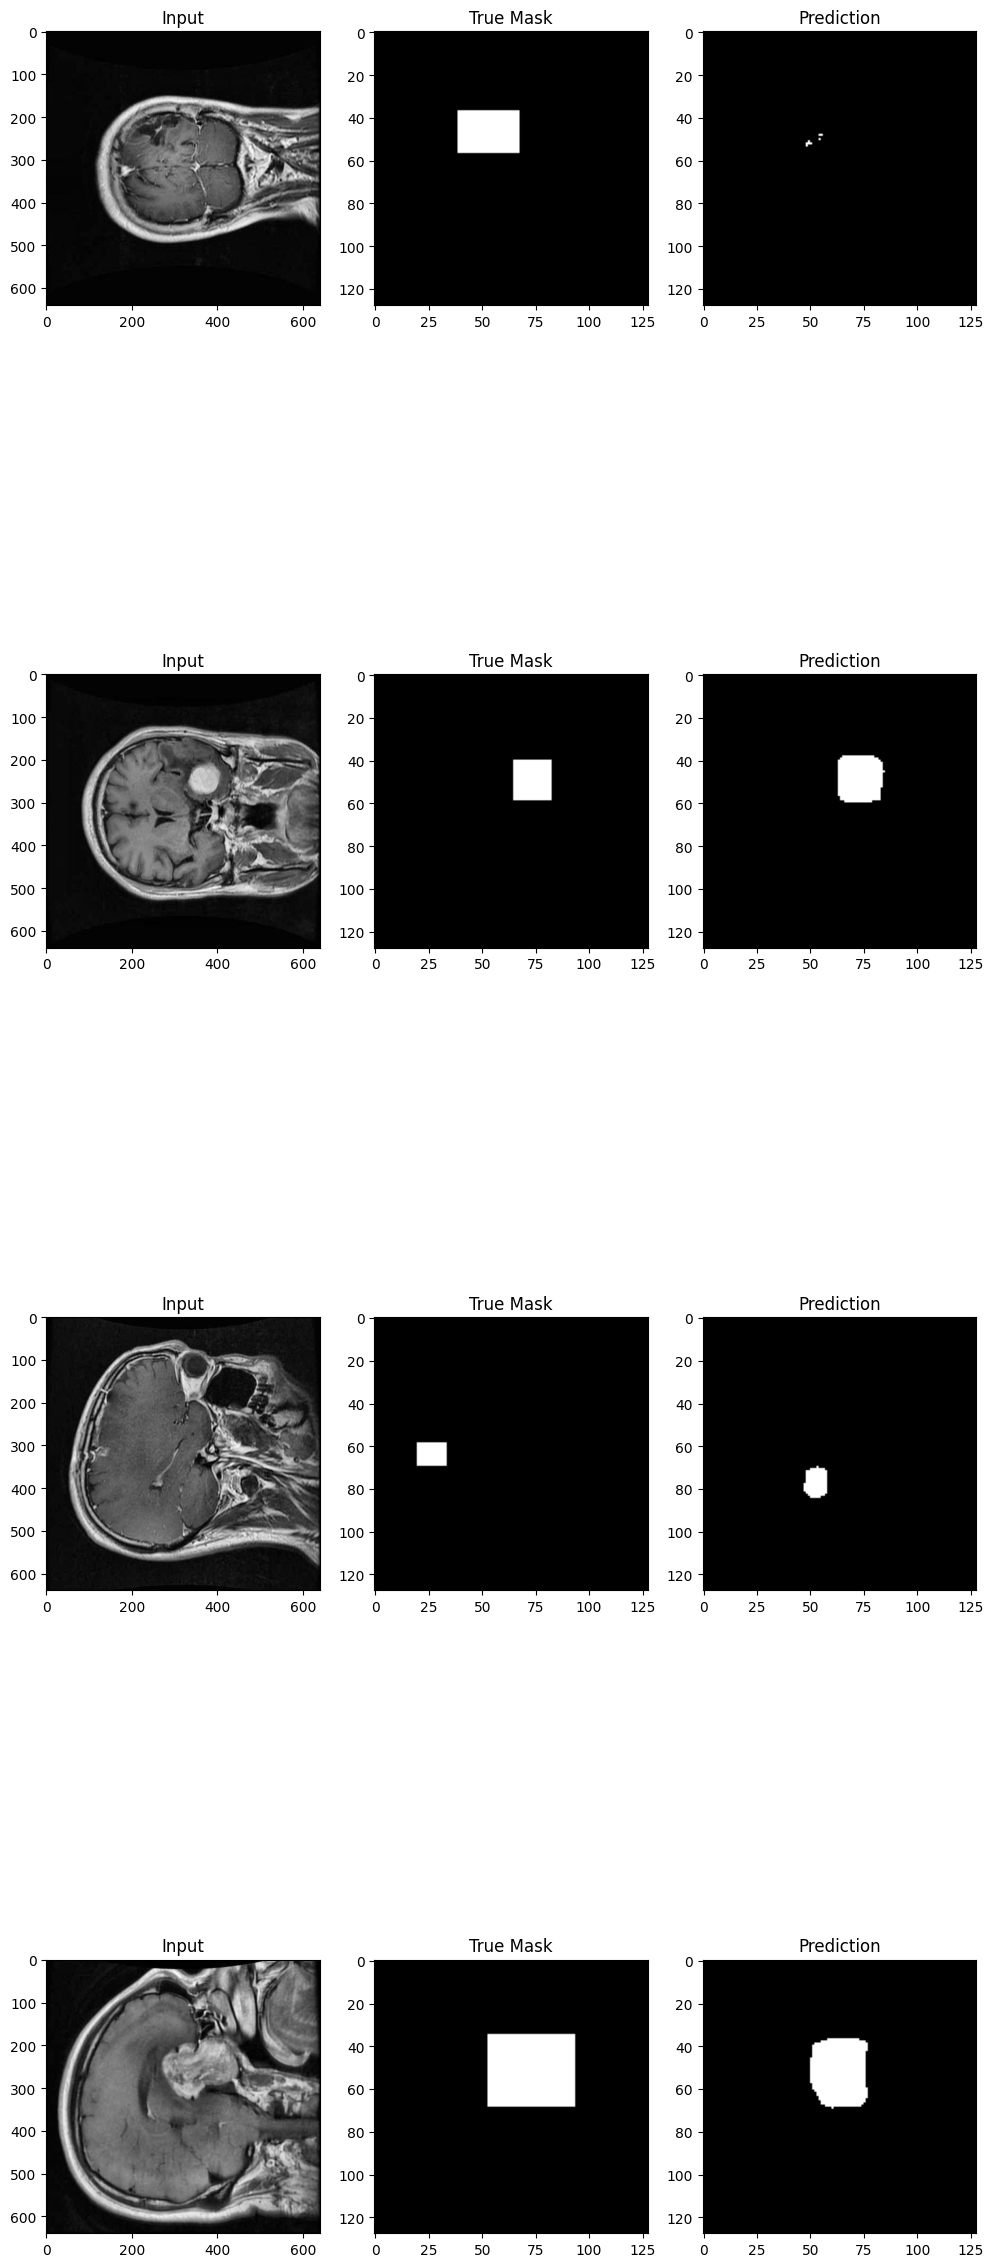

In [39]:
test_random_images(n=4)

# SegNet

In [40]:
def attention_block(x, g, inter_channels):
    
    theta_x = Conv2D(inter_channels, (1, 1), strides=(1, 1), padding='same')(x)
    phi_g = Conv2D(inter_channels, (1, 1), strides=(1, 1), padding='same')(g)
    f = Activation('relu')(Add()([theta_x, phi_g]))
    psi_f = Conv2D(1, (1, 1), strides=(1, 1), padding='same')(f)
    psi_f = Activation('sigmoid')(psi_f)
    return Multiply()([x, psi_f])

In [68]:
import tensorflow as tf
from tensorflow.keras import layers, models

def attention_gate(skip_connection, gating_signal, intermediate_channels):
    theta_x = layers.Conv2D(intermediate_channels, 1, strides=1, padding="same")(skip_connection)
    phi_g = layers.Conv2D(intermediate_channels, 1, strides=1, padding="same")(gating_signal)
    add = layers.Add()([theta_x, phi_g])
    relu = layers.Activation("relu")(add)
    
    psi = layers.Conv2D(1, 1, strides=1, padding="same")(relu)
    sigmoid = layers.Activation("sigmoid")(psi)
    
    attention = layers.Multiply()([skip_connection, sigmoid])
    return attention

def build_segnet_with_attention_gate(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D((2, 2))(conv1)

    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D((2, 2))(conv2)

    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D((2, 2))(conv3)

    conv4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = layers.MaxPooling2D((2, 2))(conv4)

    # Bottleneck
    bottleneck = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
    bottleneck = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(bottleneck)

    # Decoder with attention gates
    up4 = layers.Conv2DTranspose(512, (3, 3), strides=2, padding='same')(bottleneck)
    att4 = attention_gate(conv4, up4, intermediate_channels=512)
    merge4 = layers.Concatenate()([up4, att4])
    deconv4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(merge4)
    deconv4 = layers.BatchNormalization()(deconv4)

    up3 = layers.Conv2DTranspose(256, (3, 3), strides=2, padding='same')(deconv4)
    att3 = attention_gate(conv3, up3, intermediate_channels=256)
    merge3 = layers.Concatenate()([up3, att3])
    deconv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(merge3)
    deconv3 = layers.BatchNormalization()(deconv3)

    up2 = layers.Conv2DTranspose(128, (3, 3), strides=2, padding='same')(deconv3)
    att2 = attention_gate(conv2, up2, intermediate_channels=128)
    merge2 = layers.Concatenate()([up2, att2])
    deconv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(merge2)
    deconv2 = layers.BatchNormalization()(deconv2)

    up1 = layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same')(deconv2)
    att1 = attention_gate(conv1, up1, intermediate_channels=64)
    merge1 = layers.Concatenate()([up1, att1])
    deconv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(merge1)
    deconv1 = layers.BatchNormalization()(deconv1)

    # Output Layer
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(deconv1)

    # Define the Model
    segnet_model = models.Model(inputs, outputs, name="SegNet-with-Attention-Gates")

    return segnet_model


segnet_model = build_segnet_with_attention_gate(input_shape=(128, 128, 3))
segnet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', MeanIoU(num_classes=2),dice_coefficient])

segnet_model.summary()



Model: "SegNet-with-Attention-Gates"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_233 (Conv2D) │ (None, 128, 128,  │      1,792 │ input_layer_9[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_234 (Conv2D) │ (None, 128, 128,  │     36,928 │ conv2d_233[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_32    │ (None, 64, 64,    │          0 │ conv2d_234[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_235 (Conv2D) │ (None, 64, 64,    │     73,856 │ max_pooling2d_32… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_236 (Conv2D) │ (None, 64, 64,    │    147,584 │ conv2d_235[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_33    │ (None, 32, 32,    │          0 │ conv2d_236[0][0]  │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_237 (Conv2D) │ (None, 32, 32,    │    295,168 │ max_pooling2d_33… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_238 (Conv2D) │ (None, 32, 32,    │    590,080 │ conv2d_237[0][0]  │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_34    │ (None, 16, 16,    │          0 │ conv2d_238[0][0]  │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_239 (Conv2D) │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_34… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_240 (Conv2D) │ (None, 16, 16,    │  2,359,808 │ conv2d_239[0][0]  │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_35    │ (None, 8, 8, 512) │          0 │ conv2d_240[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_241 (Conv2D) │ (None, 8, 8,      │  4,719,616 │ max_pooling2d_35… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_242 (Conv2D) │ (None, 8, 8,      │  9,438,208 │ conv2d_241[0][0]  │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_28 │ (None, 16, 16,    │  4,719,104 │ conv2d_242[0][0]  │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_243 (Conv2D) │ (None, 16, 16,    │    262,656 │ conv2d_240[0][0]

 Total params: 32,081,989 (122.38 MB)

 Trainable params: 32,080,069 (122.38 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [69]:
segnet_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 24s 352ms/step - accuracy: 0.6761 - dice_coefficient: 0.1389 - loss: 0.6966 - mean_io_u_11: 0.4814 - val_accuracy: 0.0798 - val_dice_coefficient: 0.0771 - val_loss: 5.4541 - val_mean_io_u_11: 0.4923
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 211ms/step - accuracy: 0.9128 - dice_coefficient: 0.2688 - loss: 0.4846 - mean_io_u_11: 0.4810 - val_accuracy: 0.3138 - val_dice_coefficient: 0.1008 - val_loss: 2.2924 - val_mean_io_u_11: 0.4811
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 211ms/step - accuracy: 0.9577 - dice_coefficient: 0.1928 - loss: 0.3156 - mean_io_u_11: 0.4812 - val_accuracy: 0.3335 - val_dice_coefficient: 0.1034 - val_loss: 3.5295 - val_mean_io_u_11: 0.4815
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 210ms/step - accuracy: 0.9613 - dice_coefficient: 0.0915 - loss: 0.2051 - mean_io_u_11: 0.4810 - val_accuracy: 0.4097 - val_dice_coefficient: 0.1153 - val_loss: 3.6471 - val_mean_io_u_11: 0.4859
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 211ms/step - a

Saliency map saved to: /kaggle/working/Segnet-Saliency_Output.png


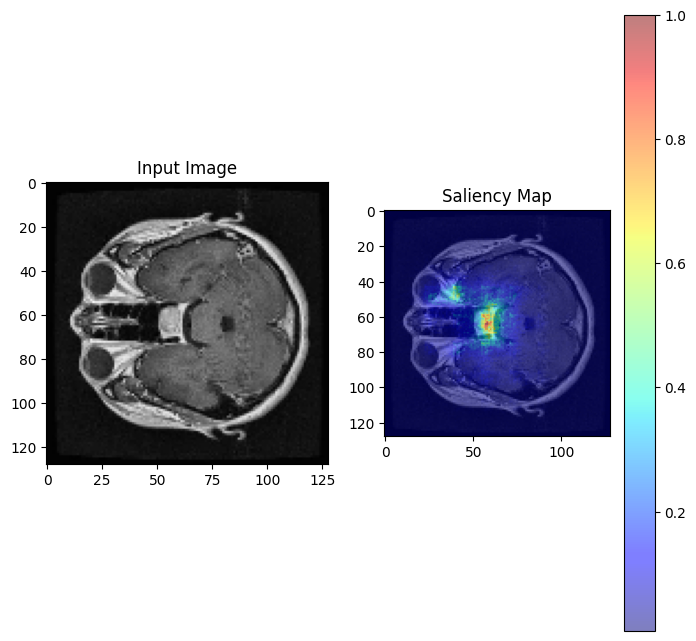

In [44]:
last_conv_layer_name = "conv2d_88"  

input_image_path = '/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/train/1000_jpg.rf.1c16148495900a466a53f121ec6af0a9.jpg'  # Adjust the image path
input_image = tf.keras.preprocessing.image.load_img(input_image_path, target_size=(128, 128))  # Resize as per your U-Net
input_image = tf.keras.preprocessing.image.img_to_array(input_image) / 255.0  # Normalize to [0, 1]
input_image = np.expand_dims(input_image, axis=0)  # Add batch dimension

# Compute the saliency map
saliency_map = compute_saliency_map(segnet_model, input_image, last_conv_layer_name)

save_path = "/kaggle/working/Segnet-Saliency_Output.png"
plot_saliency_map(input_image, saliency_map,save_path)

In [45]:
def test_random_images(n=5):
    test_mask_dir = '/kaggle/working/test_masks/'
    indices = np.random.randint(0, len(test_annotation['images']), size=n)
    images = [test_annotation['images'][i] for i in indices]
    annotations = [test_annotation['annotations'][i] for i in indices]
    
    j = 1
    plt.figure(figsize=(12, 4 * 2 * n))
    for img, ann in zip(images, annotations):
        
        image = cv2.imread(test_path + img['file_name'])
        plt.subplot(n, 3, j)
        j += 1
        plt.imshow(image)
        plt.title("Input")
        
        mask = predict(test_path + img['file_name'], segnet_model)
        
        result_image = np.zeros_like(mask, dtype=np.uint8)
        result_image[mask == 1] = 255
        
        true_mask = cv2.imread(test_mask_dir + img['file_name'], cv2.IMREAD_GRAYSCALE)
        true_mask_resized = cv2.resize(true_mask, (mask.shape[1], mask.shape[0]), interpolation=cv2.INTER_NEAREST)
        true_mask_binary = (true_mask_resized > 127).astype(np.uint8)  
        
        plt.subplot(n, 3, j)
        j += 1
        plt.imshow(true_mask_binary, cmap='gray')
        plt.title("True Mask")
        
        plt.subplot(n, 3, j)
        j += 1
        plt.imshow(result_image, cmap='gray')
        plt.title("Prediction")
        
        iou_score = compute_iou(true_mask_binary, mask)
        dice_score = compute_dice(true_mask_binary, mask)
        print(f"Image: {img['file_name']}")
        print(f"  IOU Score: {iou_score:.4f}")
        print(f"  Dice Coefficient: {dice_score:.4f}")

Original Image Shape: (640, 640, 3)
Resized Image Shape: (128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
shape mask (128, 128, 1)
Image: 1258_jpg.rf.47dda44eca3ffe34f82c22bdf5115c91.jpg
  IOU Score: 0.0321
  Dice Coefficient: 7.9511
Original Image Shape: (640, 640, 3)
Resized Image Shape: (128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
shape mask (128, 128, 1)
Image: 1209_jpg.rf.e4323403c999a44e8c47683ce6a9070e.jpg
  IOU Score: 0.0006
  Dice Coefficient: 0.1551
Original Image Shape: (640, 640, 3)
Resized Image Shape: (128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
shape mask (128, 128, 1)
Image: 2620_jpg.rf.146e5672193cf1a2b957290fa68985f5.jpg
  IOU Score: 0.0293
  Dice Coefficient: 7.2794
Original Image Shape: (640, 640, 3)
Resized Image Shape: (128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
shape mask (128, 128, 1)
Image: 2924_jpg.rf.1faf11f7c125adc8f124030599a3719d.jpg
  IOU Score: 0.0172
  Dice Coefficient: 4.3165


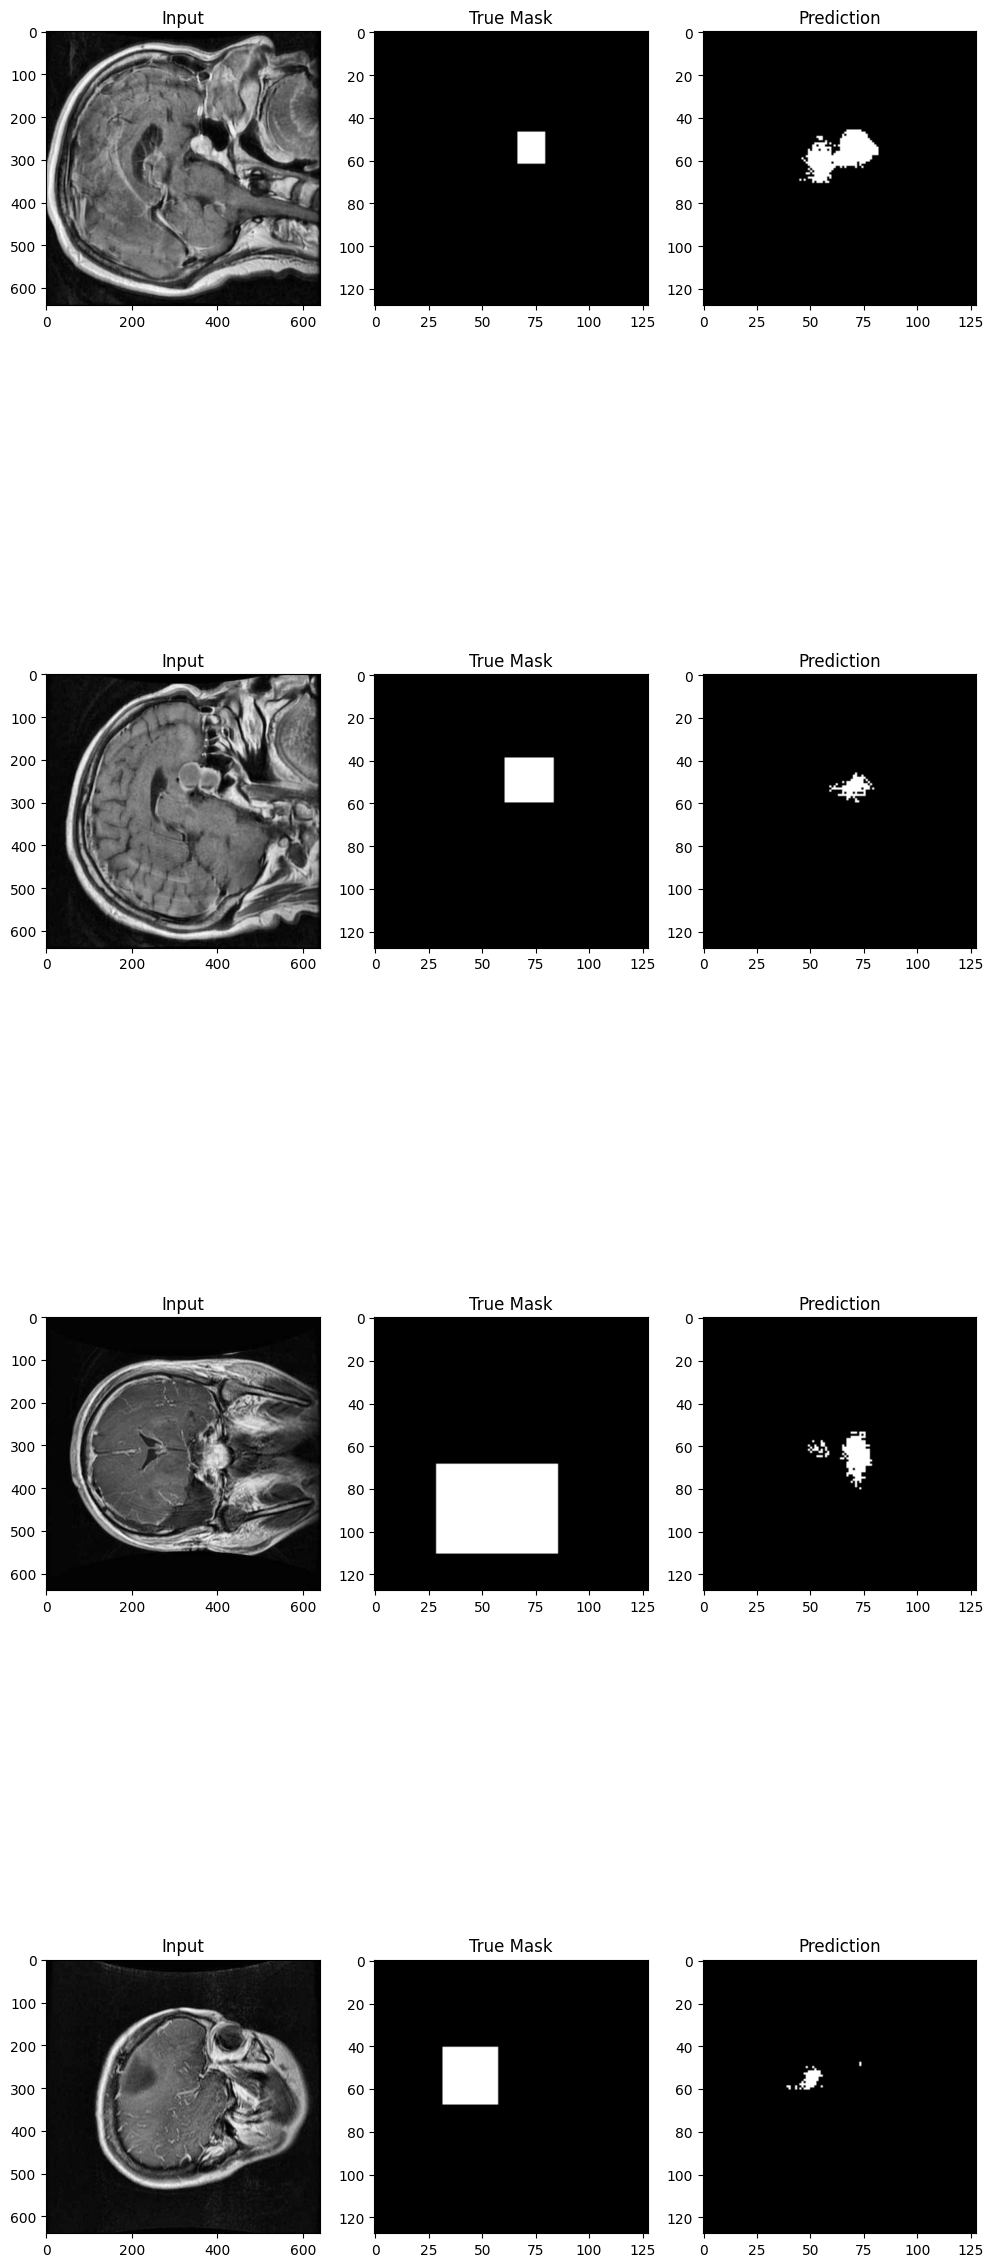

In [46]:
test_random_images(n=4)

# DeepLab

In [52]:
from tensorflow.keras import layers, Model

def atrous_spatial_pyramid_pooling(input_tensor):
    """
    Implements Atrous Spatial Pyramid Pooling (ASPP).
    """
    dims = input_tensor.shape
    # Global Average Pooling
    pool = layers.GlobalAveragePooling2D()(input_tensor)
    pool = layers.Reshape((1, 1, dims[-1]))(pool)
    pool = layers.Conv2D(256, (1, 1), padding='same', activation='relu')(pool)
    pool = layers.UpSampling2D(size=(dims[1], dims[2]), interpolation='bilinear')(pool)

    # 1x1 Convolution
    conv_1x1 = layers.Conv2D(256, (1, 1), padding='same', activation='relu')(input_tensor)

    # 3x3 Convolutions with different dilation rates
    conv_3x3_1 = layers.Conv2D(256, (3, 3), dilation_rate=6, padding='same', activation='relu')(input_tensor)
    conv_3x3_2 = layers.Conv2D(256, (3, 3), dilation_rate=12, padding='same', activation='relu')(input_tensor)
    conv_3x3_3 = layers.Conv2D(256, (3, 3), dilation_rate=18, padding='same', activation='relu')(input_tensor)

    # Concatenate the outputs
    output = layers.Concatenate()([pool, conv_1x1, conv_3x3_1, conv_3x3_2, conv_3x3_3])
    output = layers.Conv2D(256, (1, 1), padding='same', activation='relu')(output)
    return output

def build_deep_lab_model(input_shape=(128, 128, 3)):
    inputs = layers.Input(shape=input_shape)

    # Encoder: Example using simple convolutional layers
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(inputs)
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)

    # Atrous Spatial Pyramid Pooling (ASPP)
    x = atrous_spatial_pyramid_pooling(x)

    # Decoder
    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(x)
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(x)
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)

    # Output layer for binary segmentation
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(x)

    # Create the model
    model = Model(inputs, outputs, name="DeepLab_Like_Model_Binary")
    return model

# Example usage
dl_model = build_deep_lab_model()
dl_model.summary()


Model: "DeepLab_Like_Model_Binary"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_105 (Conv2D) │ (None, 128, 128,  │      1,792 │ input_layer_4[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_106 (Conv2D) │ (None, 128, 128,  │     36,928 │ conv2d_105[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (None, 64, 64,    │          0 │ conv2d_106[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_107 (Conv2D) │ (None, 64, 64,    │     73,856 │ max_pooling2d_14… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_108 (Conv2D) │ (None, 64, 64,    │    147,584 │ conv2d_107[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_15    │ (None, 32, 32,    │          0 │ conv2d_108[0][0]  │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_109 (Conv2D) │ (None, 32, 32,    │    295,168 │ max_pooling2d_15… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_110 (Conv2D) │ (None, 32, 32,    │    590,080 │ conv2d_109[0][0]  │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ conv2d_110[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 1, 1, 256) │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_111 (Conv2D) │ (None, 1, 1, 256) │     65,792 │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_3     │ (None, 32, 32,    │          0 │ conv2d_111[0][0]  │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_112 (Conv2D) │ (None, 32, 32,    │     65,792 │ conv2d_110[0][0]  │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_113 (Conv2D) │ (None, 32, 32,    │    590,080 │ conv2d_110[0][0]  │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_114 (Conv2D) │ (None, 32, 32,    │    590,080 │ conv2d_110[0][0]  │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_115 (Conv2D) │ (None, 32, 32,    │    590,080 │ conv2d_110[0][0]  │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 4,334,145 (16.53 MB)

 Trainable params: 4,334,145 (16.53 MB)

 Non-trainable params: 0 (0.00 B)

In [53]:
dl_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', MeanIoU(num_classes=2), dice_coefficient])

In [54]:
dl_model.fit(
    X_train,  
    y_train,  
    epochs=20,  
    batch_size=32,  
    validation_split=0.2,
    verbose=1  
)

Epoch 1/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 18s 324ms/step - accuracy: 0.9042 - dice_coefficient: 7.4965e-04 - loss: 0.3087 - mean_io_u_5: 0.4810 - val_accuracy: 0.9622 - val_dice_coefficient: 0.0000e+00 - val_loss: 0.1158 - val_mean_io_u_5: 0.4811
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 228ms/step - accuracy: 0.9625 - dice_coefficient: 0.0000e+00 - loss: 0.1114 - mean_io_u_5: 0.4810 - val_accuracy: 0.9622 - val_dice_coefficient: 0.0000e+00 - val_loss: 0.1102 - val_mean_io_u_5: 0.4811
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 228ms/step - accuracy: 0.9630 - dice_coefficient: 0.0000e+00 - loss: 0.1074 - mean_io_u_5: 0.4812 - val_accuracy: 0.9622 - val_dice_coefficient: 0.0000e+00 - val_loss: 0.1091 - val_mean_io_u_5: 0.4811
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 228ms/step - accuracy: 0.9631 - dice_coefficient: 0.0000e+00 - loss: 0.1051 - mean_io_u_5: 0.4813 - val_accuracy: 0.9622 - val_dice_coefficient: 0.0000e+00 - val_loss: 0.1087 - val_mean_io_u_5: 0.4811
Epoch 5/20
38/38 ━━━━━━━━━━━━━━

Saliency map saved to: /kaggle/working/Segnet-Saliency_Output.png


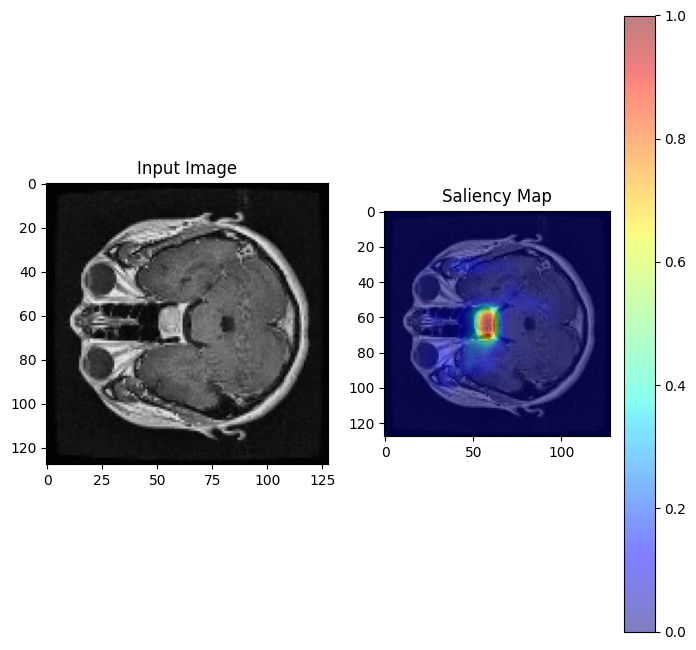

In [76]:
last_conv_layer_name = "conv2d_120"  

# Load and preprocess the input image
input_image_path = '/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/train/1000_jpg.rf.1c16148495900a466a53f121ec6af0a9.jpg'
input_image = tf.keras.preprocessing.image.load_img(input_image_path, target_size=(128, 128))  
input_image = tf.keras.preprocessing.image.img_to_array(input_image) / 255.0  
input_image = np.expand_dims(input_image, axis=0)  # Add batch dimension

# Compute the saliency map
saliency_map = compute_saliency_map(dl_model, input_image, last_conv_layer_name)

save_path = "/kaggle/working/Segnet-Saliency_Output.png"
# Visualize the input image and its saliency map
plot_saliency_map(input_image, saliency_map,save_path)

In [77]:
def visualize_segmentation_results(num_images=5):
    mask_directory = '/kaggle/working/test_masks/'
    random_indices = np.random.randint(0, len(annotation_data['images']), num_images)
    sample_images = [annotation_data['images'][index] for index in random_indices]
    sample_annotations = [annotation_data['annotations'][index] for index in random_indices]
    
    figure, axes = plt.subplots(num_images, 3, figsize=(12, 4 * 2 * num_images))
    
    for idx, (img_info, ann_info) in enumerate(zip(sample_images, sample_annotations)):
        image_path = image_base_path + img_info['file_name']
        input_image = cv2.imread(image_path)
        
        axes[idx, 0].imshow(input_image)
        axes[idx, 0].set_title("Original Image")
        axes[idx, 0].axis('off')
        
        predicted_mask = generate_mask(image_path, trained_model)
        
        mask_display = np.zeros_like(predicted_mask, dtype=np.uint8)
        mask_display[predicted_mask == 1] = 255
        
        ground_truth_path = mask_directory + img_info['file_name']
        ground_truth_mask = cv2.imread(ground_truth_path, cv2.IMREAD_GRAYSCALE)
        resized_ground_truth = cv2.resize(ground_truth_mask, (predicted_mask.shape[1], predicted_mask.shape[0]), interpolation=cv2.INTER_NEAREST)
        binary_ground_truth = (resized_ground_truth > 127).astype(np.uint8)
        
        axes[idx, 1].imshow(binary_ground_truth, cmap='gray')
        axes[idx, 1].set_title("Ground Truth Mask")
        axes[idx, 1].axis('off')
        
        axes[idx, 2].imshow(mask_display, cmap='gray')
        axes[idx, 2].set_title("Predicted Mask")
        axes[idx, 2].axis('off')
        
        intersection_over_union = calculate_iou(binary_ground_truth, predicted_mask)
        dice_coefficient = calculate_dice(binary_ground_truth, predicted_mask)
        
        print(f"Image: {img_info['file_name']}")
        print(f"  IOU Score: {intersection_over_union:.4f}")
        print(f"  Dice Coefficient: {dice_coefficient:.4f}")

    plt.tight_layout()
    plt.show()


Original Image Shape: (640, 640, 3)
Resized Image Shape: (128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
shape mask (128, 128, 1)
Image: 2766_jpg.rf.c92010e2136dfc017e82fbaa23e24ae6.jpg
  IOU Score: 0.0000
  Dice Coefficient: 0.0000
Original Image Shape: (640, 640, 3)
Resized Image Shape: (128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
shape mask (128, 128, 1)
Image: 1953_jpg.rf.930f3818be5f75b586ad1bc5e476fd8c.jpg
  IOU Score: 0.0743
  Dice Coefficient: 17.7116
Original Image Shape: (640, 640, 3)
Resized Image Shape: (128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
shape mask (128, 128, 1)
Image: 2726_jpg.rf.c488735905855e1856d9400016ed3e58.jpg
  IOU Score: 0.0335
  Dice Coefficient: 8.2934
Original Image Shape: (640, 640, 3)
Resized Image Shape: (128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
shape mask (128, 128, 1)
Image: 286_jpg.rf.d1eaa196a7a452c9361f94d838e3e67a.jpg
  IOU Score: 0.0000
  Dice Coefficient: 0.0000


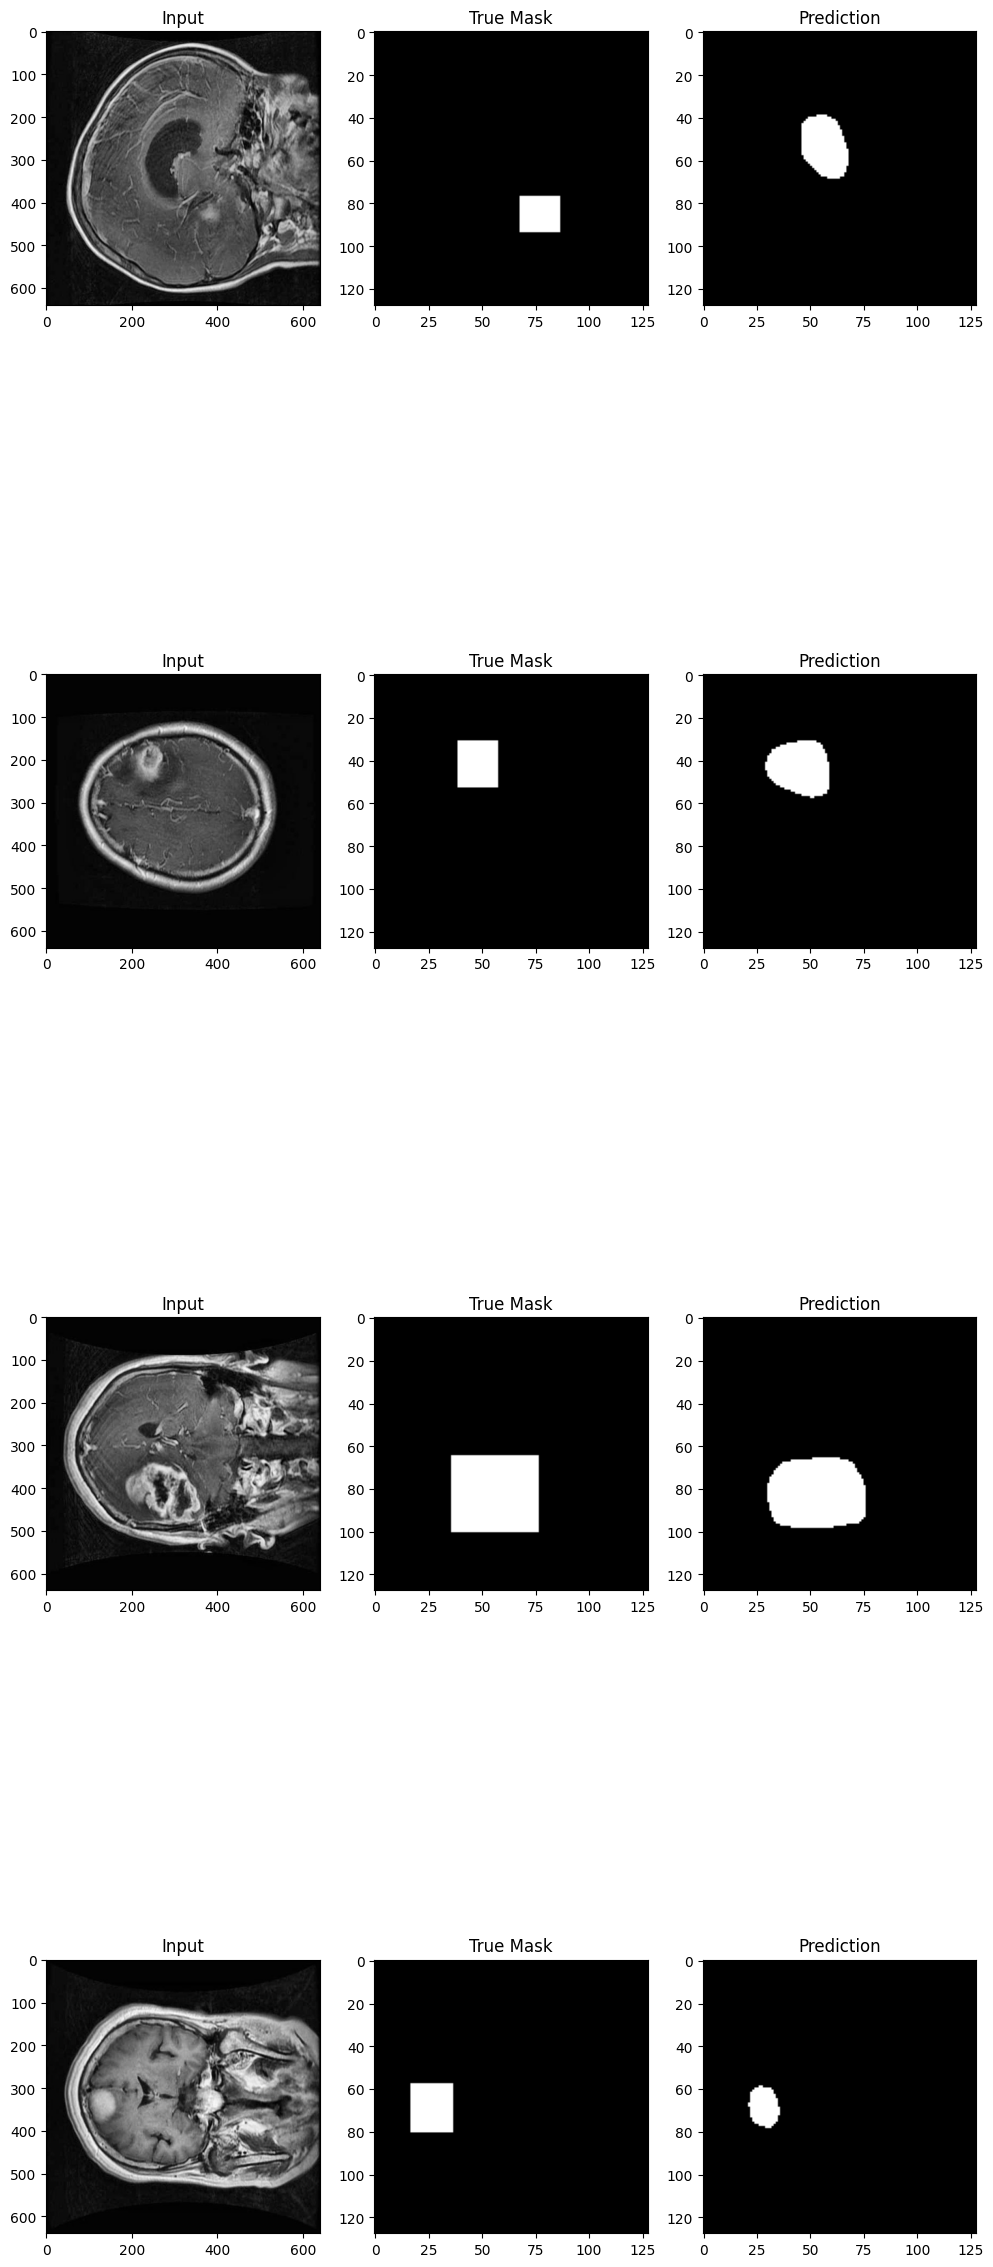

In [78]:
visualize_segmentation_results(num_images=4)